<a href="https://colab.research.google.com/github/ahmed00078/EmoVoice-Classifier-A-Comparative-Analysis-of-AI-Techniques-for-Emotion-Recognition-from-Speech/blob/main/EmoVoice_Classifier_A_Comparative_Analysis_of_AI_Techniques_for_Emotion_Recognition_from_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip ravdess-emotional-speech-audio.zip

Archive:  ravdess-emotional-speech-audio.zip
replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, VGG19, Xception, ResNet50, MobileNetV2, DenseNet121, EfficientNetB5

from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split, KFold

from flask import Flask, request

# Exemple d'un audio

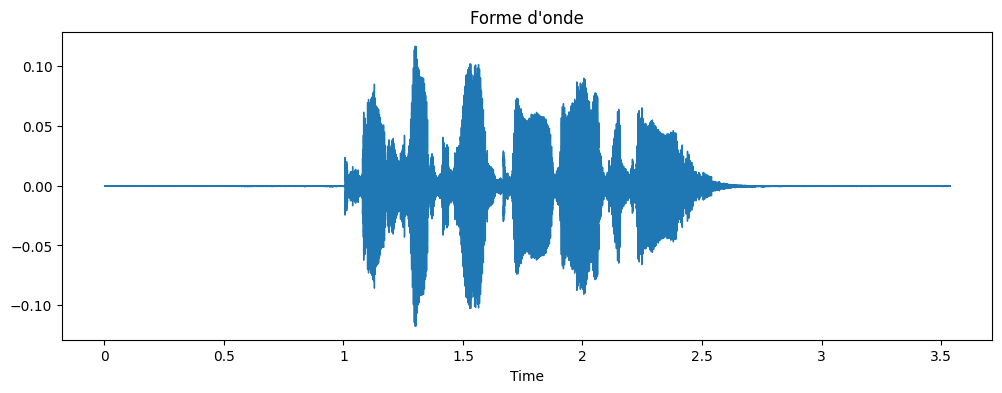

<ipython-input-67-f628a20f906d>:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


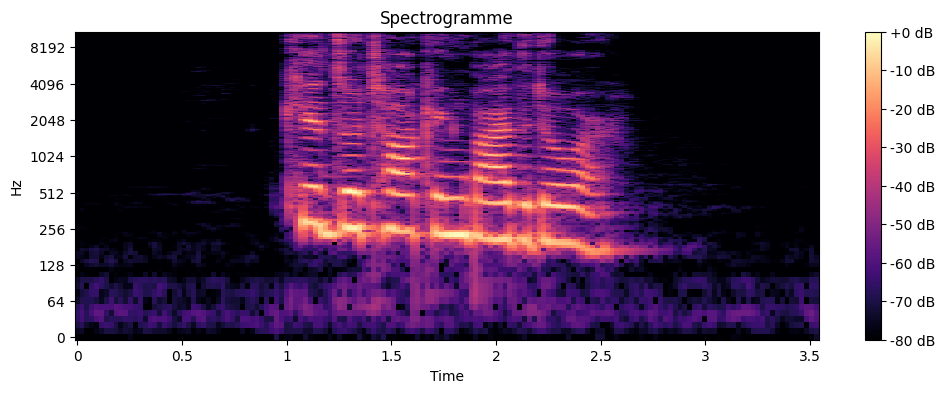

In [ ]:
import librosa
import librosa.display

# Charger le fichier audio
audio_path = '/content/Actor_10/03-01-01-01-01-01-10.wav'
y, sr = librosa.load(audio_path)

# Afficher la forme d'onde
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Forme d\'onde')
plt.show()

# Extraire le spectre de puissance
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogramme')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Les donnees

In [ ]:
import os

# Spécifiez le chemin vers le répertoire principal contenant les données audio
data_directory = '/content/audio_speech_actors_01_24'

# Créez une liste principale pour contenir les 24 listes
listes_actors = []

# Boucle sur les classes (de 1 à 24)
for actor in range(1, 25):
    if(actor <= 9):
      actor_path = os.path.join(data_directory, f'Actor_0{actor}')
    else:
      actor_path = os.path.join(data_directory, f'Actor_{actor}')

    # Créez une liste pour contenir les chemins de fichiers audio pour chaque actor
    chemins_actor = []

    # Boucle sur les fichiers audio dans chaque actor
    for audio_file in os.listdir(actor_path):
        audio_path = os.path.join(actor_path, audio_file)
        chemins_actor.append(audio_path)

    # Ajoutez la liste des chemins de fichiers de la actor à la liste principale
    listes_actors.append(chemins_actor)

# Maintenant, listes_classes contient 24 listes, chacune avec les chemins de 60 fichiers audio d'une classe spécifique

In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs, axis=1)

In [ ]:
X = []
y = []

for label, chemins_actor in enumerate(listes_actors, 1):
    for audio_path in chemins_actor:
        features = extract_features(audio_path)
        X.append(features)
        y.append(label)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM

In [ ]:
from sklearn.svm import SVC

model = SVC(C=0.1, gamma=0.1, kernel='linear')
model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='linear')

In [ ]:
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8680555555555556


In [ ]:
# Prédiction sur les ensembles d'entraînement et de test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcul des scores d'accuracy et de precision
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame({
    'Accuracy': [train_accuracy, test_accuracy],
    'Precision': [train_precision, test_precision]
}, index=['Train', 'Test'])

# Affichage des résultats
print(results_df)

       Accuracy  Precision
Train  0.977431   0.977457
Test   0.868056   0.876301


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 0.01, 0.001]}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [ ]:
best_params

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
import pandas as pd

# Création d'un modèle d'arbre de décision
decision_tree_model = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42
)
# Entraînement du modèle sur les données d'entraînement
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params_decision_tree = grid_search.best_params_

In [ ]:
best_params_decision_tree

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

In [ ]:
# Prédiction sur les données d'entraînement et de test
y_train_pred = decision_tree_model.predict(X_train)
y_test_pred = decision_tree_model.predict(X_test)

# Calcul des scores d'accuracy et de precision
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')

# Création d'un DataFrame pour afficher les résultats
results_df_decision_tree = pd.DataFrame({
    'Accuracy': [train_accuracy, test_accuracy],
    'Precision': [train_precision, test_precision]
}, index=['Train', 'Test'])

# Affichage des résultats
print(results_df_decision_tree)

       Accuracy  Precision
Train  0.881944   0.893905
Test   0.500000   0.527604
